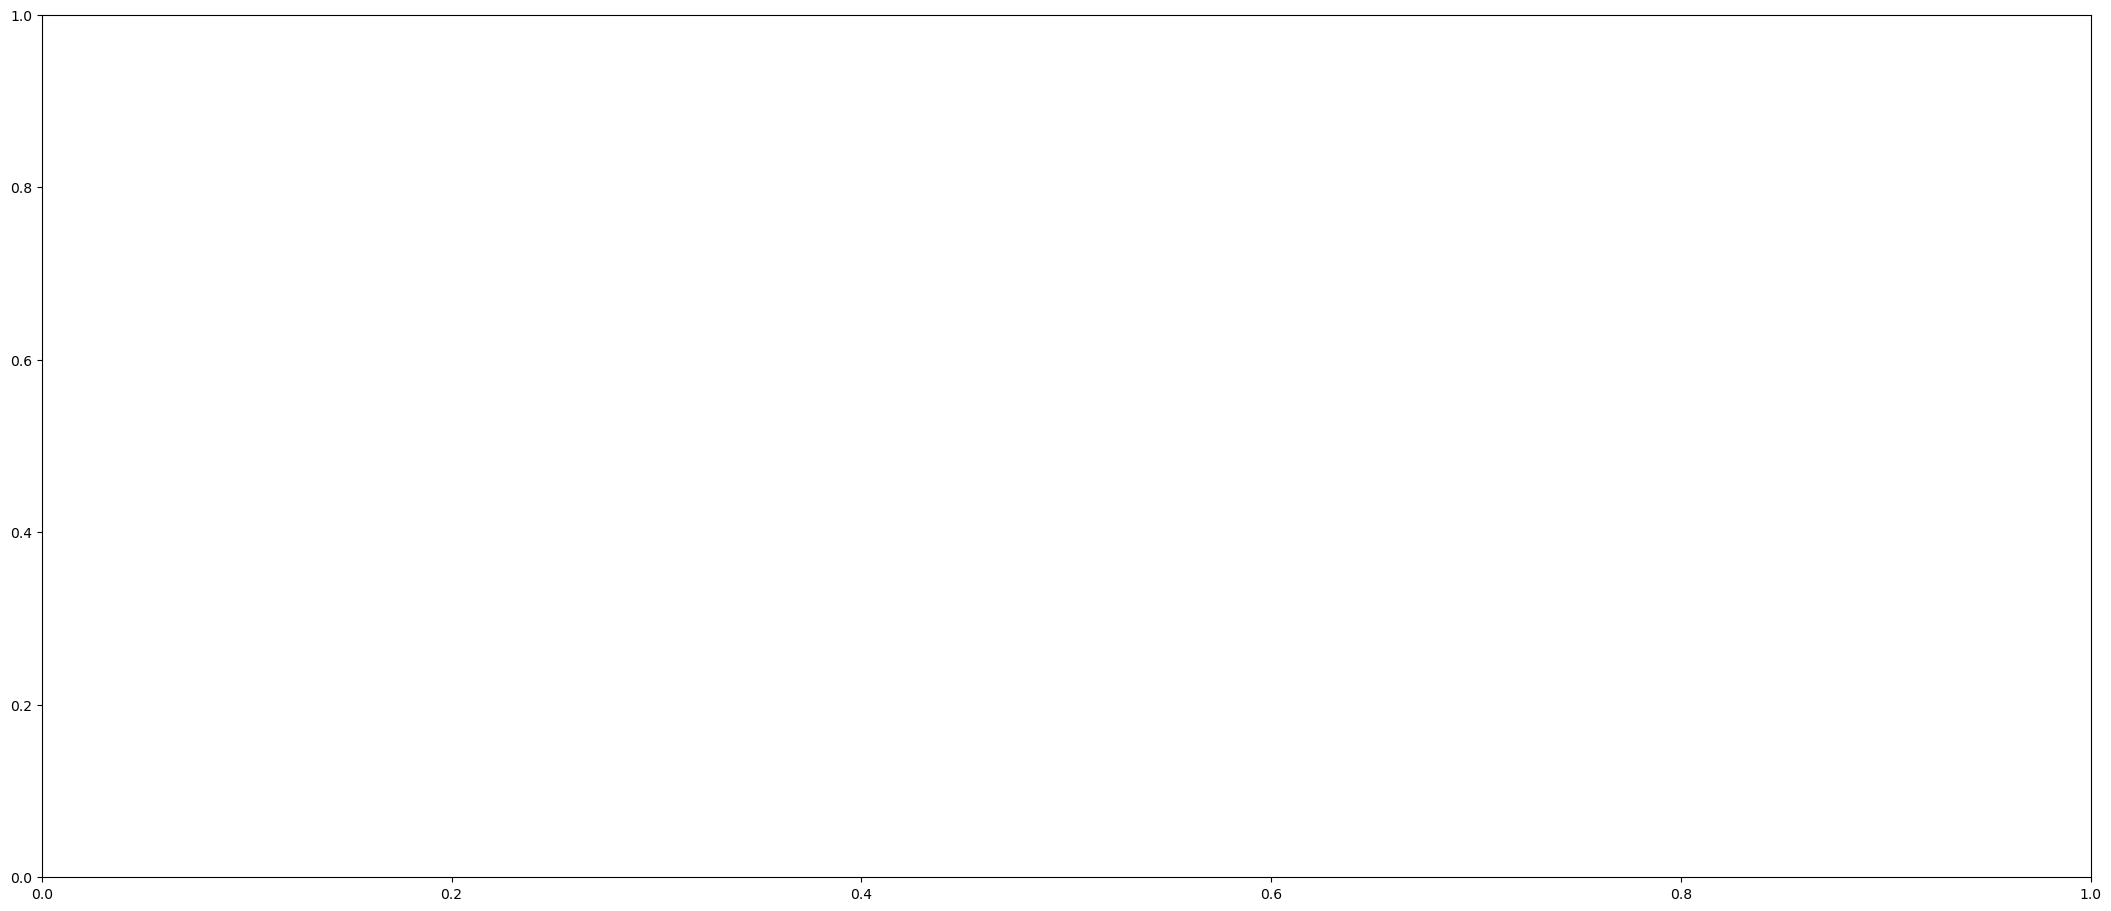

In [2]:
# Packages Used
import pandas as pd
import numpy as np
import time
import os
import os.path
from scipy import signal
from scipy.signal import find_peaks, peak_widths
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.linear_model import LinearRegression
import PySimpleGUI as sg
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk

#Creating the Canvas space
#from matplotlib.backends.backend_tkagg import NavigationToolbar2TkAgg

# Embedding the Matplotlib Toolbar Application
# ------------------------------- This is to include a matplotlib figure in a Tkinter canvas
_VARS = {'window': False,
         'fig_agg': False,
         'pltFig': False,
         'controls_cv': False}

#Defining the Tkinter canvas and space on the canvas for the i-t trace and toolbar
def draw_figure(canvas, fig):
    if canvas.children:
        for child in canvas.winfo_children():
            child.destroy()
    figure_canvas_agg = FigureCanvasTkAgg(fig, master=canvas)
    figure_canvas_agg.draw_idle()
    toolbar = NavigationToolbar2Tk(figure_canvas_agg, canvas)

    toolbar.update()
    figure_canvas_agg.get_tk_widget().pack(side='left', fill='both', expand=1)
    return figure_canvas_agg


#Defining the toolbar
class Toolbar(NavigationToolbar2Tk):
    def __init__(self, *args, **kwargs):
        super(Toolbar, self).__init__(*args, **kwargs)

#Defining save functions 
def save(dataFrame, baseDirectory, fileName, text, modifier):
    analysis_folder = os.path.join(baseDirectory, (fileName + "_Peak Analysis")).replace("\\", "/")
    os.makedirs(os.path.join(baseDirectory, analysis_folder), exist_ok=True)
    completeName = os.path.join(analysis_folder, fileName + text + modifier + ".txt").replace("\\", "/")
    dataFrame.to_csv(completeName)
    
def SaveParameters(toFile, baseDirectory, fileName, text, modifier):
    parameters_folder = os.path.join(baseDirectory, (fileName + "_Peak Analysis"),'Fitting Parameters').replace("\\", "/")
    os.makedirs(os.path.join(baseDirectory, parameters_folder), exist_ok=True)
    completeName = os.path.join(parameters_folder, text + modifier + ".txt").replace("\\", "/")
    file1 = open(completeName, "w")
    file1.write(toFile)
    file1.close()
    

# ------------------------------- Analysis Functions

#Opening dataset and assigning columns
def open_dataset(fileName):
    columns_i = [1,2]
    data_i = pd.read_csv(fileName, sep=",", names = columns_i)
    columns = [data_i[1][0],data_i[2][0]]
    data = data_i[1:].rename(columns = {1:columns[0], 2:columns[1]}).reset_index(drop = True).apply(pd.to_numeric)
    return data, columns

#Defining ALS   
def als_baseline(y, lam, p):
    
    niter = 10
    
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z    
    
#Define als baseline of data sections
def current_sections(current):
    seperated_current = []
    factor = 10000  # This is the length in number of data points of each section of data. It is arbitrary.

    for i in range(0,len(current),factor):
        xmin = i
        xmax = i+factor

        #Indexing current and time based on +- range around peak
        current_section = np.array(current[xmin:xmax])

        #Appending lists
        seperated_current.append(current_section)
    
        if(i==len(current)):
            break
    
    return seperated_current

def als_baseline_sections(current_sections, lam, p):
    baseline = []
    
    for i in range(0,len(current_sections)):
        p = np.array(current_sections[i])

        baseline_section = als_baseline(p, lam, p)
        
        baseline.extend(baseline_section)
        
        i = i+1
        if(i==len(current_sections)):
            break
    
    return baseline

    
#Define Peak Finder
def peak_finder(currentData, min_width, min_prom):
    peaks, properties = find_peaks(currentData, width=(min_width,None), prominence=(min_prom, None))
    return peaks, properties["widths"], properties["width_heights"], properties["left_ips"], properties["right_ips"]


#Define dataframe for original data, ALS baseline, and data - ALS
def dataframe_it(time, current, baseline, difference):    
    Results_df = pd.DataFrame({columns[0]: time, 
                               columns[1]: current,  
                               ("Baseline" + columns[1]): baseline, 
                               ("Baseline Subtracted" + columns[1]): difference})
    return Results_df

#Define dataframe for peak finding
def dataframe_peaks(time, current, width, peakhalf, t1, t2):
    Results_peaks = pd.DataFrame({columns[0]: time, columns[1]: current, "Peak Width/s": width, 
                                  "Peak 1/2 /A": peakhalf, "T1/s":t1, "T2/s":t2}) 
    return Results_peaks   

def dataframe_bSubPeaks(time, current, bSubCurrent, width, peakhalf, t1, t2):
    Results_peaks = pd.DataFrame({columns[0]: time, columns[1]: current, ("bSub" + columns[1]): bSubCurrent, 
                                  "Peak Width/s": width, "Peak 1/2 /A": peakhalf, "T1/s":t1, "T2/s":t2}) 
    return Results_peaks
    
# ------------------------------- Plot Functions
#Defining the plots with data
def DrawPlot():
    ax1.clear()
    
    #making the plots
    current_line, = ax1.plot(time, current, label='Current', linewidth=3, color="#1f77b4")
    baseline_line, = ax1.plot(time, baseline, label='Baseline', linewidth=3, color='#ff7f0e')
    
    peaks_scatter = ax1.scatter(timeP1, currentP1, label='Peaks', color='red', s=150, zorder=10)
    bSub_peaks_scatter = ax1.scatter(timeP2, currentP2, label='bSub Peaks', color='black', marker='x', s=200, zorder=10)
    
    #Can only plot the hlines for the non-baseline subtracted peak analysis in the UI plot.
    peak_width1 = ax1.hlines(y=width_height1, xmin=min_fwhm1, xmax=max_fwhm1, color = "red")
    
    
    #labeling the plot
    ax1.set_xlabel(columns[0], fontsize=20)
    ax1.set_ylabel(columns[1], fontsize=20)
    ax1.tick_params(axis='both', labelsize=15)
    ax1.legend(fontsize=10)
    
    #plot
    _VARS['fig_agg'] = draw_figure(
    _VARS['window']['figCanvas'].TKCanvas, _VARS['pltFig'])
    
    _VARS['lines'] = {'current': current_line, 'baseline': baseline_line}
    _VARS['scatters'] = {'peaks': peaks_scatter, 'bSub_peaks': bSub_peaks_scatter}
    _VARS['hlines'] = {'width1': peak_width1}

    
def UpdatePlot():
    _VARS['lines']['baseline'].set_ydata(baseline)
    _VARS['scatters']['peaks'].set_offsets(np.column_stack((timeP1, currentP1)))
    _VARS['scatters']['bSub_peaks'].set_offsets(np.column_stack((timeP2, currentP2)))
    _VARS['hlines']['width1'].remove() #cannot update the hlines like the other plot elements
    _VARS['hlines']['width1'] = ax1.hlines(y=width_height1, xmin=min_fwhm1, xmax=max_fwhm1, color="red")
    _VARS['fig_agg'].draw()
    
    
# PySimpleGUI
# ------------------------------- PySimpleGUI CODE

#Initial Slider Values
#baseline
slider_lam_range = (1, 12)
slider_lam_res   = 0.5

slider_asy_range = (0,1)
slider_asy_res   = 0.01

#peak finding
slider_wid_range = (1, 25)
slider_wid_res   = 1

min_slider_prom_range = 0
max_slider_prom_range = 100
slider_prom_res       = (max_slider_prom_range-min_slider_prom_range)/1000

#baseline subtracted peak finding
slider_wid_range2 = (1, 25)
slider_wid_res2   = 1


min_slider_prom_range2 = 0
max_slider_prom_range2 = 100
slider_prom_res2       = (max_slider_prom_range2-min_slider_prom_range2)/1000

#Initial Values
#Initial filename and sample rate
full_path = r''
input_samplerate = ""

#initial values asymmetric least squares baseline
lam_value = (slider_lam_range[1]/2)
p_value = (slider_asy_range[1]/2)
niter_value = 10

#initial values for non-background subtracted peak detection
wid = 1
prom = (max_slider_prom_range/2)

#initial values for background subtracted peak detection
wid2 = 1
prom2 = (max_slider_prom_range2/2)

#Initial modifiers
modifier1 = "_1"
modifier2 = "_1"
modifier3 = "_1"


#Creating buttons, sliders, and defining the size of the i-t trace figure
layout = [
    #Line 1
    [sg.Input(key="input" ,change_submits=True, default_text = full_path), 
               sg.FileBrowse(initial_folder= 'C://Users//u1260//Desktop', key = 'Browse', enable_events=True), 
     sg.T('Sample Rate (s):', text_color = 'black', background_color = 'white', pad=((25, 2), 0)),
     sg.I(input_samplerate, key='input_samplerate', text_color = 'black', background_color = 'white', size = 12, 
              pad=((0), 0)),
     sg.B('Open', key="open", button_color= ('white', 'blue'), pad=((25, 2), 0)),
     sg.B('Exit', button_color= ('white', 'firebrick3'), size = (6, 1), pad=((1015, 0), 0))],
    
    #Line Space
    [sg.T('', text_color = 'white', background_color = 'white', pad=((0, 10)))],
    
    #Line 2
    [sg.T('Baseline Fit:', text_color = 'black', background_color = 'white', pad=((128, 55), 0)),
     sg.T('smoothness', text_color = 'black', background_color = 'white', pad=((0, 0), 0)),
     sg.Slider(range=slider_lam_range, resolution=slider_lam_res, default_value=lam_value, key="slider1", 
               orientation = 'h', size =(25,15), background_color = 'white', text_color = 'black', enable_events=True),
     sg.T('asymmetry', text_color = 'black', background_color = 'white', pad=((25, 95), 0)), 
     sg.Slider(range=slider_asy_range, resolution=slider_asy_res, orientation = 'h', size =(25,15), default_value=p_value, 
               background_color = 'white', text_color = 'black', key="slider2", enable_events=True),
     sg.I(modifier1, key='modifier1_input', text_color = 'black', background_color = 'white', size = 10, 
              pad=((113, 0), 0)),
     sg.B('Save', button_color= ('white', 'green'), key = 'Save1')],
    
    #Line 3
    [sg.T('Peak Finding:', text_color = 'black', background_color = 'white', pad=((121, 86), 0)),
     sg.T('width', text_color = 'black', background_color = 'white'),
     sg.Slider(range=slider_wid_range, resolution=slider_wid_res, orientation = 'h', size =(25,15), default_value=wid, 
               background_color = 'white', text_color = 'black', key="slider3", enable_events=True), 
     sg.T('prominence', text_color = 'black', background_color = 'white', pad=((25, 5), 0)), 
     sg.I(min_slider_prom_range, key='input_min_slider_prom_range', text_color = 'black', background_color = 'white', size = 12, 
              pad=((0), 0)),
     sg.Slider(range=(min_slider_prom_range, max_slider_prom_range), resolution=slider_prom_res, orientation = 'h', size =(25,15), default_value=prom, 
               background_color = 'white', text_color = 'black', key="slider4", enable_events=True),
     sg.I(max_slider_prom_range, key='input_max_slider_prom_range', text_color = 'black', background_color = 'white', size = 12, 
              pad=((0), 0)),
     sg.I(modifier2, key='modifier2_input', text_color = 'black', background_color = 'white', size = 10, pad=((25, 0), 0)),
     sg.B('Save', button_color= ('white', 'green'), key = "Save2")],    
    
    #Line 4
    [sg.T('Baseline Subtracted Peak Finding:', text_color = 'black', background_color = 'white', pad=((0, 86), 0)),
     sg.T('width', text_color = 'black', background_color = 'white'),
     sg.Slider(range=slider_wid_range2, resolution=slider_wid_res2, orientation = 'h', size =(25,15), default_value=wid2, 
               background_color = 'white', text_color = 'black', key="slider5", enable_events=True), 
     sg.T('prominence', text_color = 'black', background_color = 'white', pad=((25, 5), 0)), 
     sg.I(min_slider_prom_range2, key='input_min_slider_prom_range2', text_color = 'black', background_color = 'white', size = 12, 
              pad=((0), 0)),
     sg.Slider(range=(min_slider_prom_range2,max_slider_prom_range2), resolution=slider_prom_res2, orientation = 'h', size =(25,15), default_value=prom2, 
               background_color = 'white', text_color = 'black', key="slider6", enable_events=True),
     sg.I(max_slider_prom_range2, key='input_max_slider_prom_range2', text_color = 'black', background_color = 'white', size = 12, 
              pad=((0), 0)),
     sg.I(modifier3, key='modifier3_input', text_color = 'black', background_color = 'white', size = 10, pad=((25, 0), 0)),
     sg.B('Save', button_color= ('white', 'green'), key = "Save3"),],
    
    #Line 5
    [sg.B('Update', button_color=('white', 'Blue'), key="Update", size=(20, 1), pad=((532, 0), (15, 0)), bind_return_key=True)],
    
    #Line 6
    [sg.Canvas(key='figCanvas',
               size=(10, 10),
               background_color='#ffffff')]
]
     
#Defining the size and location of the Tkinter canvas
_VARS['window'] = sg.Window('Peak Analysis',
                            layout,
                            return_keyboard_events=True,
                            finalize=True,
                            size=(1600,950),
                            resizable=True,
                            location=(20, 20),
                            background_color= '#ffffff') #DAE0E6')

#plot layout
_VARS['pltFig'] = plt.figure(constrained_layout=True, figsize=(21, 9))
ax1 = _VARS['pltFig'].add_subplot(1, 1, 1)


#Actions
while True:
    event, values = _VARS['window'].read()
    if event in (sg.WIN_CLOSED, 'Exit'):  #always give a way out
        break

    #Buttons 
    elif event == "open":
        full_path = values['input']
        sample_rate = values['input_samplerate']
        
        if full_path == '' or full_path == 'Please Select a File':
            full_path = 'Please Select a File'
            _VARS['window'].Element("input").update(value=full_path)
            
        elif sample_rate == '' or sample_rate == 'Input Value':
            sample_rate = 'Input Value'
            _VARS['window'].Element("input_samplerate").update(value=sample_rate)
        
        else:          
            base_directory,file_name = os.path.split(full_path)
            base_file_name, extension = os.path.splitext(file_name)

            #Data Management
            sample_rate       = float(values['input_samplerate'])
            data              = open_dataset(full_path)[0]
            columns           = open_dataset(full_path)[1]
            time              = (sample_rate*(np.array(range(0, (len(data[columns[0]]))))))+data[columns[0]][0]
            current           = np.array(data[columns[1]])
            sep_current       = current_sections(current)
            baseline          = als_baseline_sections(sep_current, (10**lam_value), p_value)
            bSub_current      = current - baseline
            #Non-baseline Subtracted Peaks
            peaks1, width1, width_height1, l_ips1, r_ips1 = peak_finder(current, wid, prom)
            fwhmP1            = width1*sample_rate
            min_fwhm1         = (l_ips1*sample_rate)+data[columns[0]][0]
            max_fwhm1         = (r_ips1*sample_rate)+data[columns[0]][0]
            currentP1         = current[peaks1]
            timeP1            = time[peaks1]
            #Baseline Subtracted Peaks
            bSubPeaks2, width2, width_height2, l_ips2, r_ips2 = peak_finder(bSub_current, wid2, prom2)
            fwhmP2            = width2*sample_rate
            min_fwhm2         = (l_ips2*sample_rate)+data[columns[0]][0]
            max_fwhm2         = (r_ips2*sample_rate)+data[columns[0]][0]        
            bSub_currentPeaks2= bSub_current[bSubPeaks2]
            currentP2         = current[bSubPeaks2]
            timeP2            = time[bSubPeaks2]
            DrawPlot()
            
        
    elif event == "Save1":
        if full_path == '' or full_path == 'Please Select a File':
            full_path = 'Please Select a File'
            _VARS['window'].Element("input").update(value=full_path)
        else:            
            modifier1 = values['modifier1_input']
            results_it = dataframe_it(time, current, baseline, bSub_current)
            file_id1 = "_baseline_bSub"            
            save(results_it, base_directory, base_file_name, file_id1, modifier1)
            
            #Text document with baseline fit parameters
            file_id2 = "Baseline_fit_parameters"       
            parameters1 = ("File Name: " + str(full_path) + "\n" + 
                          "File Modifier: " + str(modifier1) + "\n\n"
                          "Baseline Fit:\n" +  
                          "Smoothness = " + str(lam_value) + "\n" + 
                          "Asymmetry = " + str(p_value)
                         )
            SaveParameters(parameters1, base_directory, base_file_name, file_id2, modifier1)

        
    elif event == "Save2":
        if full_path == '' or full_path == 'Please Select a File':
            full_path = 'Please Select a File'
            _VARS['window'].Element("input").update(value=full_path)
        else:
            modifier2         = values['modifier2_input']
            results_peaks     = dataframe_peaks(timeP1, currentP1, fwhmP1, width_height1, min_fwhm1, max_fwhm1)
            file_id3           = "_Peaks"
            save(results_peaks, base_directory, base_file_name, file_id3, modifier2)
        
            #Text document with peak fit parameters
            file_id4      = "Peak_analysis_parameters"       
            parameters2 = ("File Name: " + str(full_path) + "\n" + 
                          "File Modifier: " + str(modifier2) + "\n\n"
                          "Peak Analysis:\n" +  
                          "Width = " + str(wid) + "\n" + 
                          "Prominence= " + str(prom)
                         )
            SaveParameters(parameters2, base_directory, base_file_name, file_id4, modifier2)
            
    elif event == "Save3":
        if full_path == '' or full_path == 'Please Select a File':
            full_path = 'Please Select a File'
            _VARS['window'].Element("input").update(value=full_path)
        else:
            modifier3         = values['modifier3_input']
            results_bSubPeaks = dataframe_bSubPeaks(timeP2, currentP2, bSub_currentPeaks2, fwhmP2, width_height2, min_fwhm2, max_fwhm2)
            file_id           = "_bSubPeaks"
            save(results_bSubPeaks, base_directory, base_file_name, file_id, modifier3)   
            
            #Text document with peak fit parameters
            file_id5      = "bSub_Peak_analysis_parameters"       
            parameters3 = ("File Name: " + str(full_path) + "\n" + 
                          "File Modifier: " + str(modifier3) + "\n\n"
                          "Baseline Subtracted Peak Analysis:\n" +  
                          "Width = " + str(wid2) + "\n" + 
                          "Prominence= " + str(prom2)
                         )
            SaveParameters(parameters3, base_directory, base_file_name, file_id5, modifier3)
            
    
    elif event == "Update":
        if full_path == '' or full_path == 'Please Select a File':
            full_path = 'Please Select a File'
            _VARS['window'].Element("input").update(value=full_path)
        else:
            #Update slider ranges with user input
            #slider 4
            min_slider_prom_range = float(values['input_min_slider_prom_range'])
            max_slider_prom_range = float(values['input_max_slider_prom_range'])
            slider_prom_res = float((max_slider_prom_range - min_slider_prom_range) / 1000)
            
            slider_element = _VARS['window']["slider4"]
            slider_element.Widget.config(from_=min_slider_prom_range, to=max_slider_prom_range, resolution=slider_prom_res)
            slider_element.update(range=(min_slider_prom_range, max_slider_prom_range))
            
            #slider 6
            min_slider_prom_range2 = float(values['input_min_slider_prom_range2'])
            max_slider_prom_range2 = float(values['input_max_slider_prom_range2'])
            slider_prom_res2 = float((max_slider_prom_range2 - min_slider_prom_range2) / 1000)
            
            slider_element = _VARS['window']["slider6"]
            slider_element.Widget.config(from_=min_slider_prom_range2, to=max_slider_prom_range2, resolution=slider_prom_res2)
            slider_element.update(range=(min_slider_prom_range2, max_slider_prom_range2))

            #Updating baseline parameters
            baseline          = als_baseline_sections(sep_current, (10**lam_value), p_value)
            bSub_current      = current - baseline
            #Updating Non-baseline Subtracted Peak Parameters 
            peaks1, width1, width_height1, l_ips1, r_ips1 = peak_finder(current, wid, prom)
            fwhmP1            = width1*sample_rate
            min_fwhm1         = (l_ips1*sample_rate)+data[columns[0]][0]
            max_fwhm1         = (r_ips1*sample_rate)+data[columns[0]][0]
            currentP1         = current[peaks1]
            timeP1            = time[peaks1]
            #Updating Baseline Subtracted Peak Parameters
            bSubPeaks2, width2, width_height2, l_ips2, r_ips2 = peak_finder(bSub_current, wid2, prom2)
            fwhmP2            = width2*sample_rate
            min_fwhm2         = (l_ips2*sample_rate)+data[columns[0]][0]
            max_fwhm2         = (r_ips2*sample_rate)+data[columns[0]][0]        
            bSub_currentPeaks2= bSub_current[bSubPeaks2]
            currentP2         = current[bSubPeaks2]
            timeP2            = time[bSubPeaks2]         
            UpdatePlot()
            print(len(width_height1))       
    
    #Sliders
    elif event == "slider1":
        lam_value = values["slider1"]
        _VARS['window'].Element("slider1").update(lam_value)
    
    elif event == "slider2":
        p_value = values["slider2"]
        _VARS['window'].Element("slider2").update(p_value)
    
    elif event == "slider3":
        wid = values["slider3"]
        _VARS['window'].Element("slider3").update(wid)
    
    elif event == "slider4":
        prom = values["slider4"]
        _VARS['window'].Element("slider4").update(prom)
        
    elif event == "slider5":
        wid2 = values["slider5"]
        _VARS['window'].Element("slider5").update(wid2)
    
    elif event == "slider6":
        prom2 = values["slider6"]
        _VARS['window'].Element("slider6").update(prom2)

_VARS['window'].close()
     
     

5